In [1]:
# change to correct working directory
# %pwd
%cd ..
%pwd

/home/felix/bluebird/energy-aware-computing


'/home/felix/bluebird/energy-aware-computing'

In [2]:
# load the auto-reload extension
%load_ext autoreload
%autoreload 2

In [3]:
import hvplot
import hvplot.pandas
import holoviews as hv
from bokeh.models import HoverTool
from gpyjoules.util import TimestampInfo
from gpyjoules.new_analysis import *
import bokeh.themes
from pathlib import Path
import pandas as pd
import json
import numpy as np
import holoviews as hv
from holoviews import opts
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error

In [4]:
from gpyjoules.models import ClockModel, PowerModel, DelayModel, EnergyModel, EnergyDelayProductModel

In [5]:
v100 = DataLoader("data/t4-3/")
v100_pl = v100.experiments["power-limit"]

In [6]:
p_max_nominal = 300
p_min_nominal = 150
f_max = 1530

In [7]:
p_max_nominal = 175
p_min_nominal = 100
f_max = 875

In [8]:
# T4
p_max_nominal = 70
p_min_nominal = 60
f_max = 1590

In [9]:
p_baseline = v100_pl.baseline_sd.as_baseline() / 1_000
p_max = p_max_nominal - p_baseline
p_baseline,p_max

(9.320860139860141, 60.679139860139856)

In [10]:
v100_pl.baseline_hd.as_baseline()/1_000, v100_pl.baseline_sd.as_baseline()/1_000

(9.32877966101695, 9.320860139860141)

In [11]:
v100_pl.baseline_hd.data["power"].std()/1_000, v100_pl.baseline_sd.data["power"].std()/1_000

(0.33841542859516327, 0.2761067325128595)

In [12]:
def get_all_agg(exp):
    all_agg = []
    for bench in exp.benchmarks.values():
        print(bench.name)
        tmp = bench.aggregate("sd", None)#"mean")
        tmp["benchmark"] = bench.name
        all_agg.append(tmp)
    all_agg = pd.concat(all_agg)
    return all_agg

In [15]:
all_agg = get_all_agg(v100_pl)


mnist-dense
resnet
mnist-cnn
nbody
bert


In [14]:
all_agg = all_agg[all_agg["benchmark"] != "nbody"]

In [70]:
all_agg = all_agg.drop(["100W", "2505MHz,562MHz"])

KeyError: "['100W' '2505MHz,562MHz'] not found in axis"

In [16]:
all_agg = all_agg.rename(columns={"clock-gpu": "clock_gpu",
                                 "enforced-power-limit": "enforced_power_limit"})

In [17]:
all_agg["enforced_power_limit"] = all_agg["enforced_power_limit"] / 1_000

In [18]:
def get_activity_from_power(power, p_max, p_max_nominal):
    return power.loc[f"{p_max_nominal}W"].mean() / p_max

In [19]:
all_agg["total_power"] = all_agg["power"] + p_baseline
all_agg["p_util"] = all_agg.groupby("benchmark")["power"].transform(lambda power: get_activity_from_power(power=power, p_max=p_max, p_max_nominal=p_max_nominal))
all_agg["util_gpu_norm"] = all_agg["util-gpu"] / 100

all_agg["time_reference"] = all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time.loc[f"{p_max_nominal}W"].mean())
all_agg["delay"] = all_agg["timestamp"] / all_agg["time_reference"]  #all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time/time.loc["300W"].mean())

# all_agg["energy_reference"] = all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy.loc[f"{p_max}W"].mean())
# all_agg["relative_energy"] = all_agg["energy"] / all_agg["energy_reference"]#all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy/energy.loc["300W"].mean())

all_agg["relative_clock_gpu"] = all_agg["clock_gpu"] / f_max

all_agg["relative_power"] = np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=p_max, a_min=None)

In [20]:
# train clock model
clock_model = ClockModel(p_max=p_max_nominal * 1.1, f_max=f_max)
clock_model.fit(power_limit=all_agg["enforced_power_limit"],
                p_util=all_agg["util-gpu"],
                clock_gpu=all_agg["clock_gpu"])
# predict using model
all_agg["clock_gpu_hat"] = clock_model.predict(power_limit=all_agg["enforced_power_limit"],
                                               p_util=all_agg["util-gpu"])
clock_model.rsquared, np.sqrt(clock_model._model.mse_resid)

(0.8481868966649814, 73.53071484238724)

<AxesSubplot:xlabel='normalised_power_limit', ylabel='clock_gpu'>

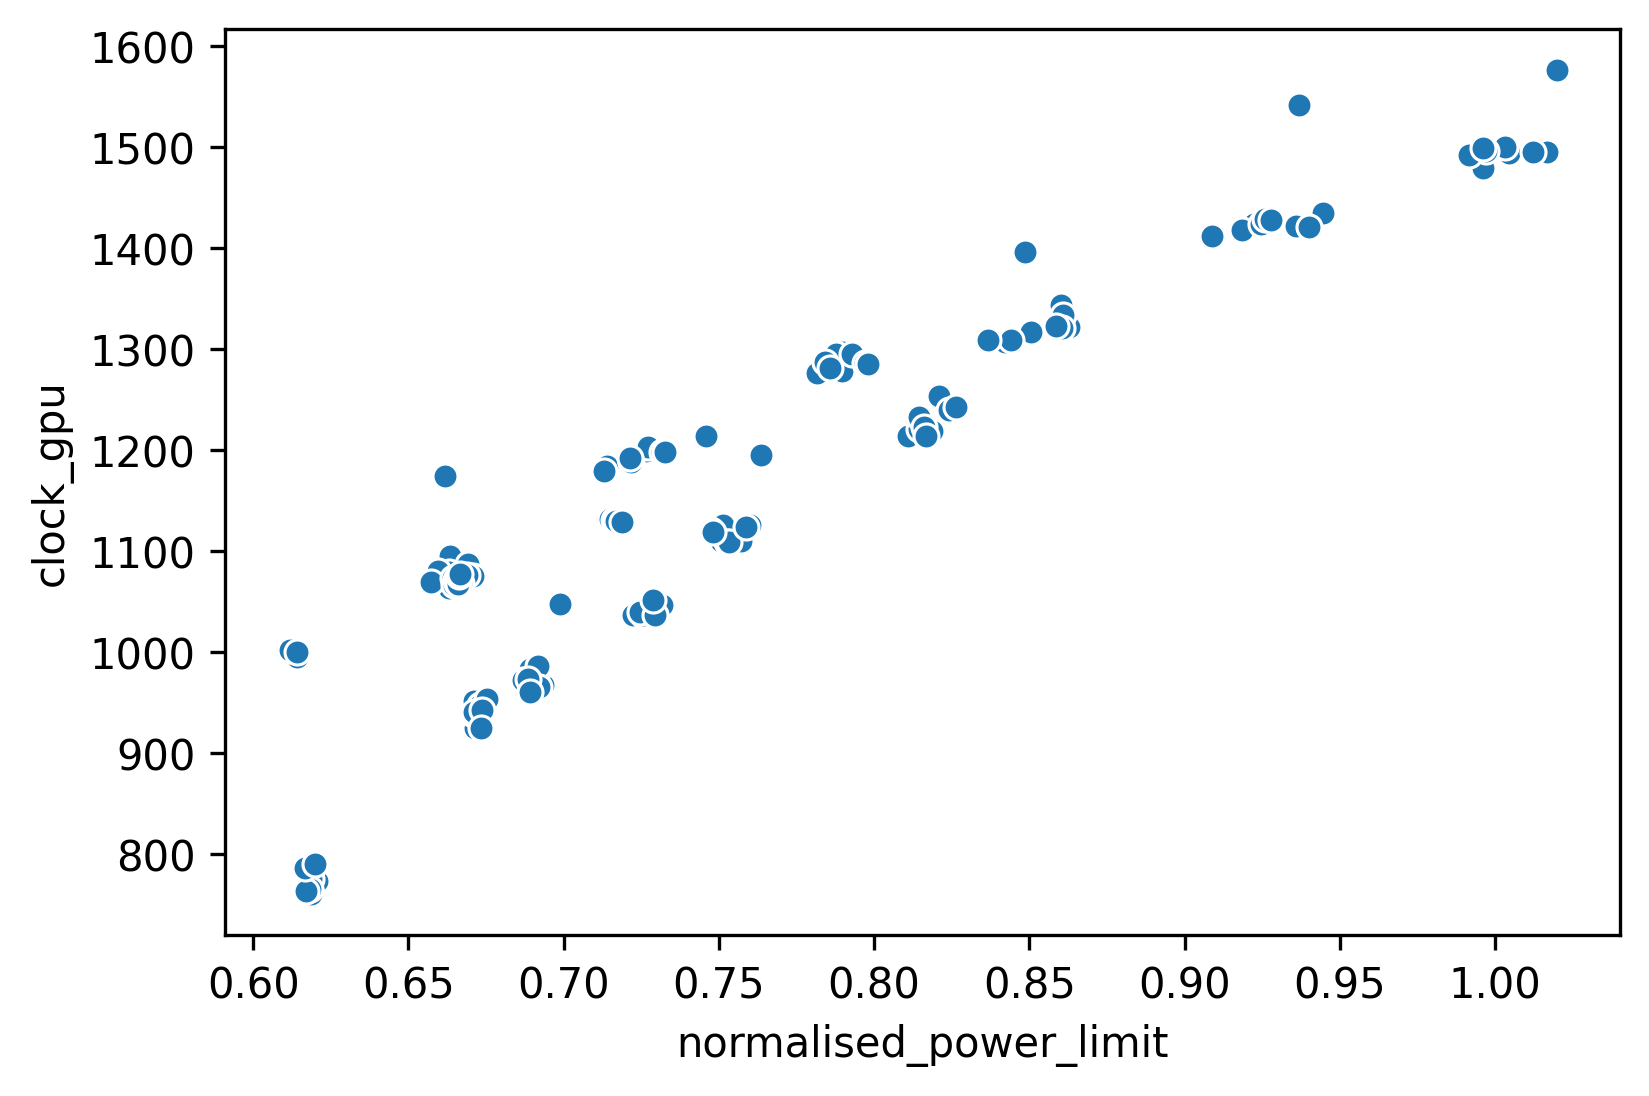

In [33]:
all_agg["normalised_power_limit"] = np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=1.8,a_min=None)#np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=p_max_nominal, a_min=None)
all_agg["normalised_power_limit"] = all_agg["enforced_power_limit"] / all_agg["util-gpu"]
sns.scatterplot("normalised_power_limit", "clock_gpu", data=all_agg)

In [24]:
power_model = PowerModel(baseline=p_baseline)
power_model.fit(p_util=all_agg["util_gpu_norm"], clock_gpu=all_agg["clock_gpu"], power=all_agg["power"])
all_agg["power_hat"] = power_model.predict(all_agg["util_gpu_norm"], all_agg["clock_gpu"])
power_model.rsquared, np.sqrt(power_model._model.mse_resid)

(0.4865276728763728, 2.7008005190100364)

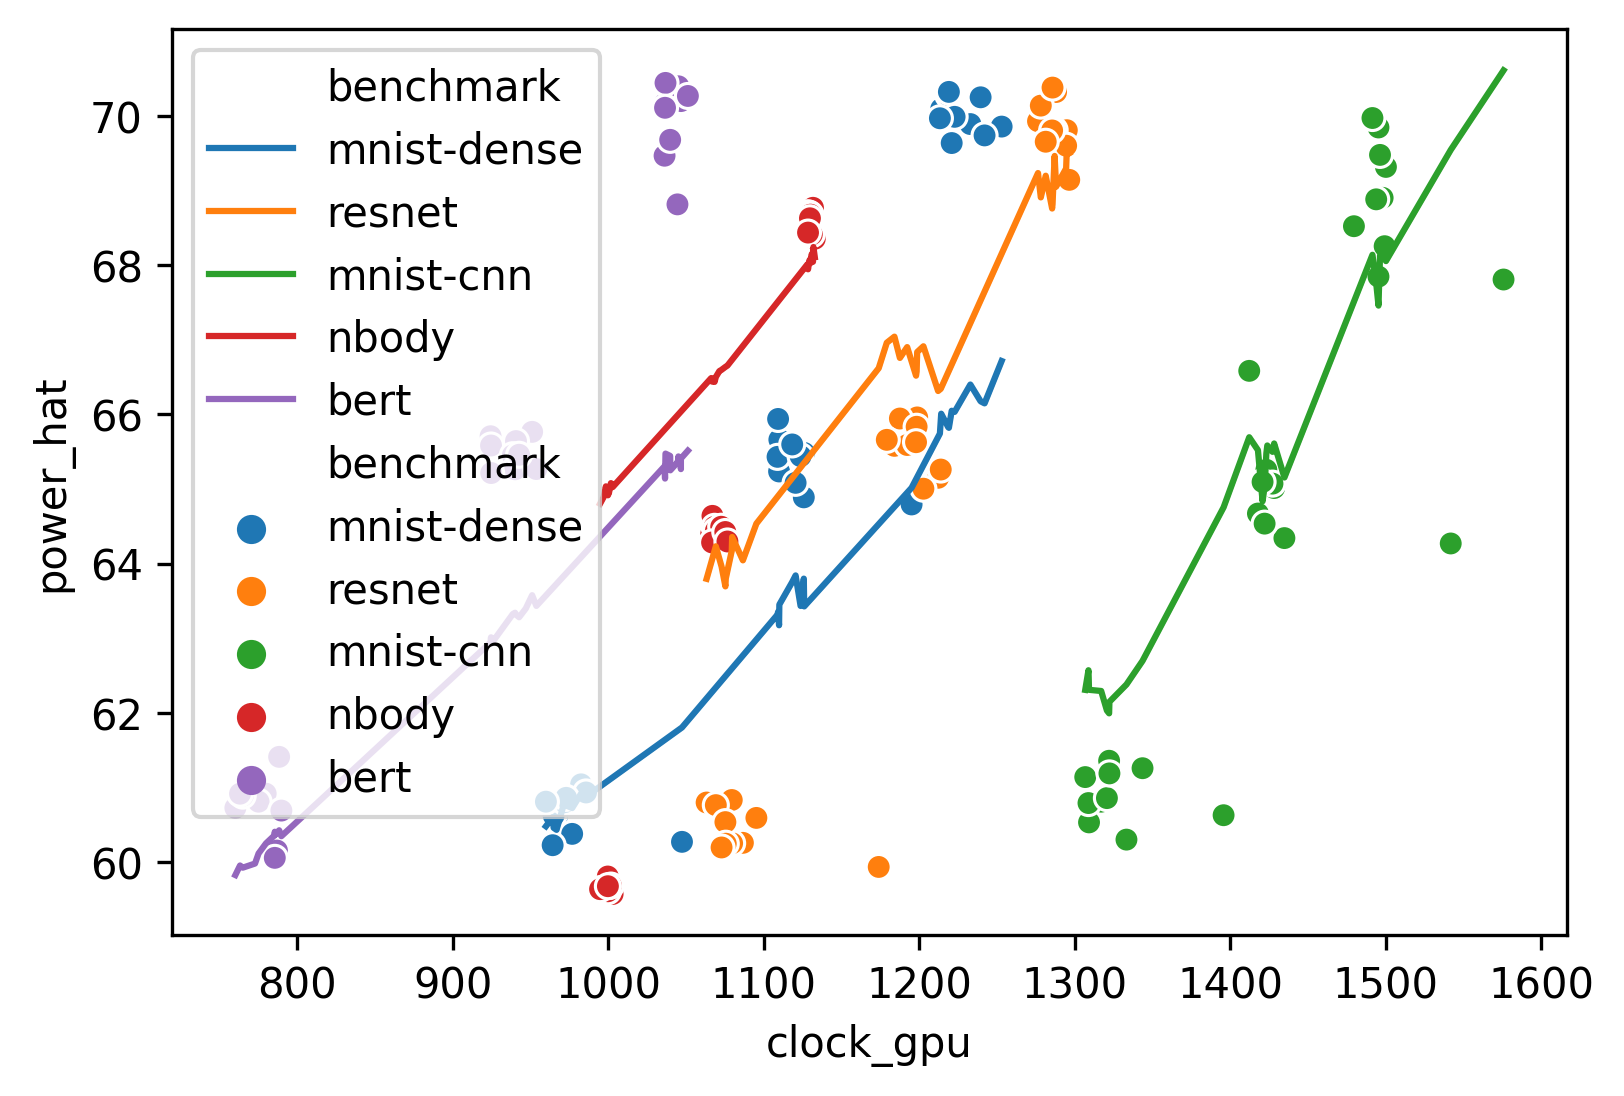

In [25]:
p_data = all_agg.copy()
p_data["p_util"] = p_data["util_gpu_norm"]
power_model.plot(p_data)

In [23]:
param_df.columns

NameError: name 'param_df' is not defined

In [68]:
def make_param_table(model, name):
    precision = 4
    fstring1 = f"{{:.{precision}f}}"
    fstring2 = f"%.{precision}f"
    param_df = model._model.conf_int()
    param_df["estimate"] = model._model.params
    param_df["95\% CI"] = "[" + param_df[0].map(lambda x: fstring1.format(x)) + ", " + param_df[1].map(lambda x: fstring1.format(x)) + "]"
    param_df = param_df.drop(columns=[0,1])
    param_df.index = [f"$\\beta_{i}$" for i in range(len(param_df))]
    print(param_df.to_latex(float_format=fstring2,
                      escape=False
         ,  label=f"tab:{name}-model-params",
                      caption=f"Parameter estimations and 95\% confidence intervals for the {name} model."
         ))

In [73]:
make_param_table(delay_model, "delay")
#make_param_table(clock_model, "clock")

\begin{table}
\centering
\caption{Parameter estimations and 95\% confidence intervals for the delay model.}
\label{tab:delay-model-params}
\begin{tabular}{lrl}
\toprule
{} &  estimate &                95\% CI \\
\midrule
$\beta_0$ &    0.3401 &       [0.2975, 0.3828] \\
$\beta_1$ & 1004.2097 &  [944.1139, 1064.3054] \\
\bottomrule
\end{tabular}
\end{table}



In [29]:
power_model._model.mse_resid/power_model._model.mse_total

0.0220267101181847

In [28]:
delay_model = DelayModel()
delay_model.fit(clock_gpu=all_agg["clock_gpu"],
                    delay=all_agg["delay"])
delay_model.rsquared, np.sqrt(delay_model._model.mse_resid)*100

(0.6026552525625233, 3.581449916902541)

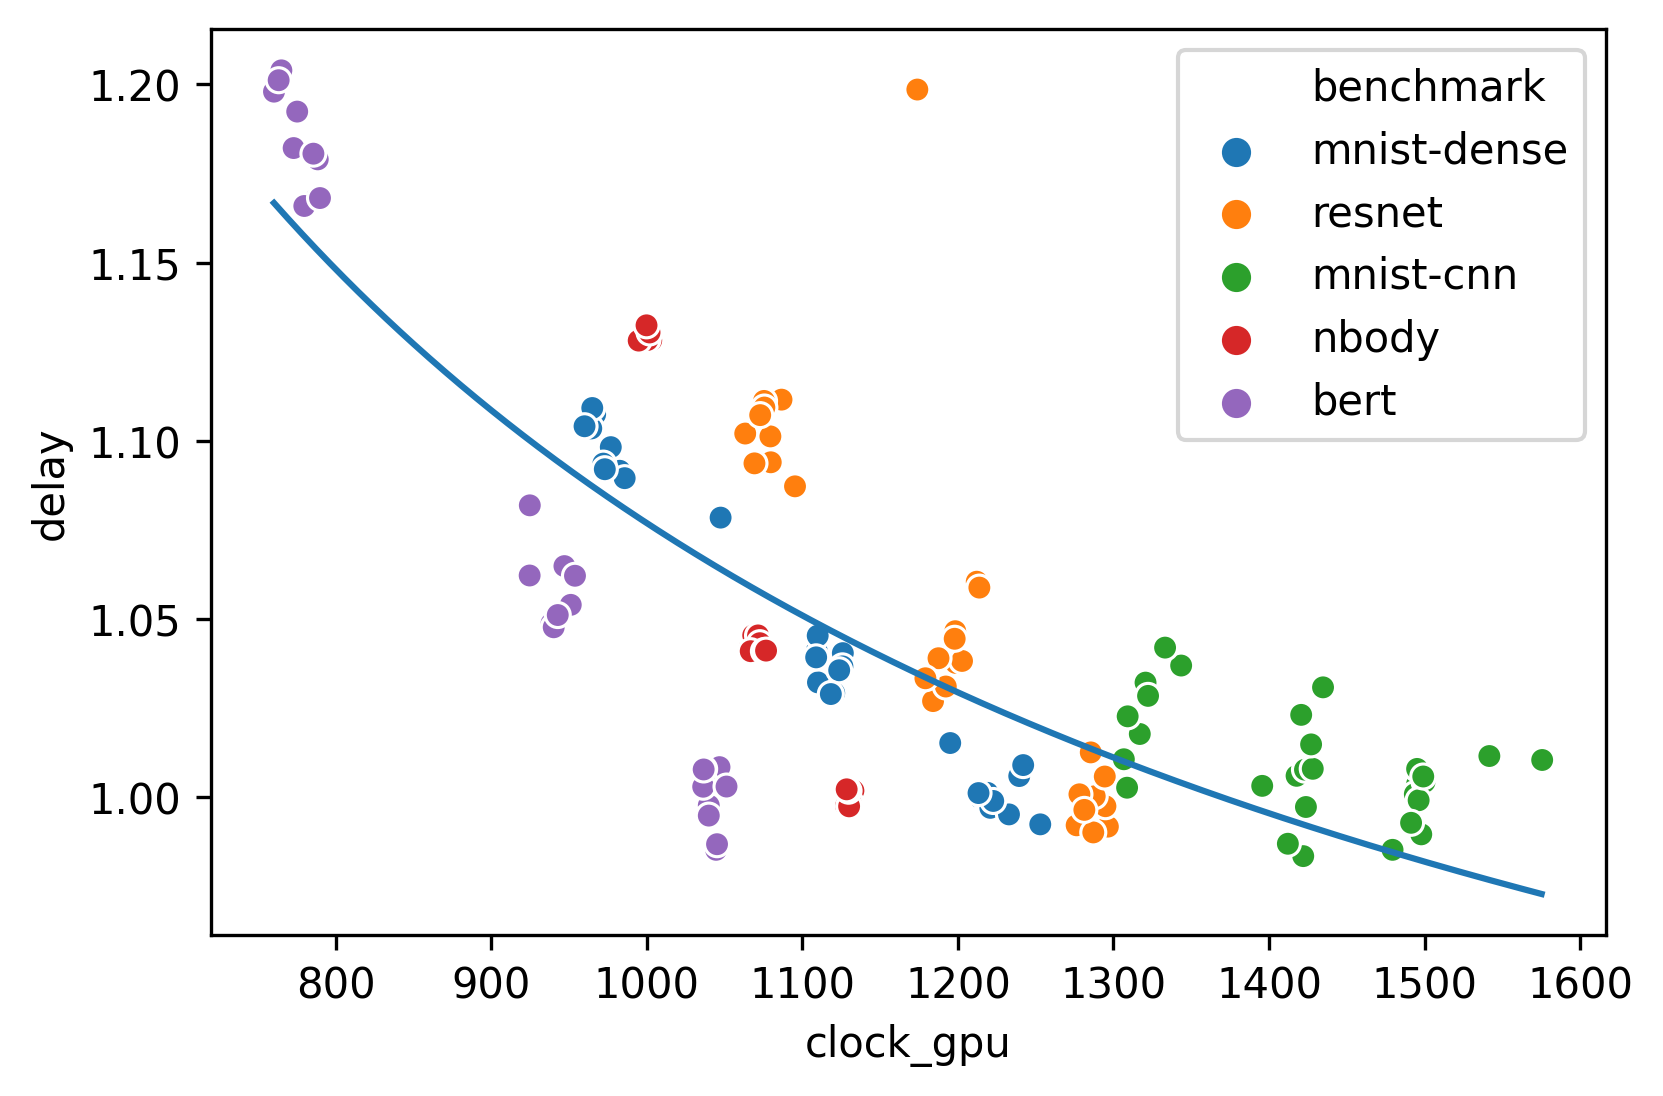

In [91]:
delay_model.plot(all_agg)

In [76]:
all_agg["delay_hat"] = delay_model.predict(clock_gpu=all_agg["clock_gpu"])

In [74]:
all_agg["delay_hat_2"] = 1 / all_agg["relative_clock_gpu"]

In [80]:
np.sqrt(mean_squared_error(all_agg["delay_hat"], all_agg["delay"]))*100

3.4837747828078367

In [81]:
np.sqrt(mean_squared_error(all_agg["delay_hat_2"], all_agg["delay"]))*100

6.286883745398018

In [84]:
r_squared(all_agg["delay"], all_agg["delay_hat_2"])

0.4977603954925538

In [29]:
energy_model = EnergyModel(delay_model=delay_model, power_model=power_model,
                           clock_model=clock_model,
                          p_min=p_min_nominal,
                          p_max=p_max_nominal)

In [30]:
def rSquare(estimations, measureds):
    """ Compute the coefficient of determination of random data. 
    This metric gives the level of confidence about the model used to model data"""
    SEE =  (( np.array(measureds) - np.array(estimations) )**2 ).sum()
    mMean = (np.array(measureds)).sum() / float(len(measureds))
    dErr = ((mMean - measureds)).sum()

    return 1 - (SEE / dErr)


In [26]:
def r_squared(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    ss_tot = np.sum((y-np.mean(y))**2)
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [31]:
rSquare(all_agg["power_hat"],all_agg["power"])

9.042042312491651e+16

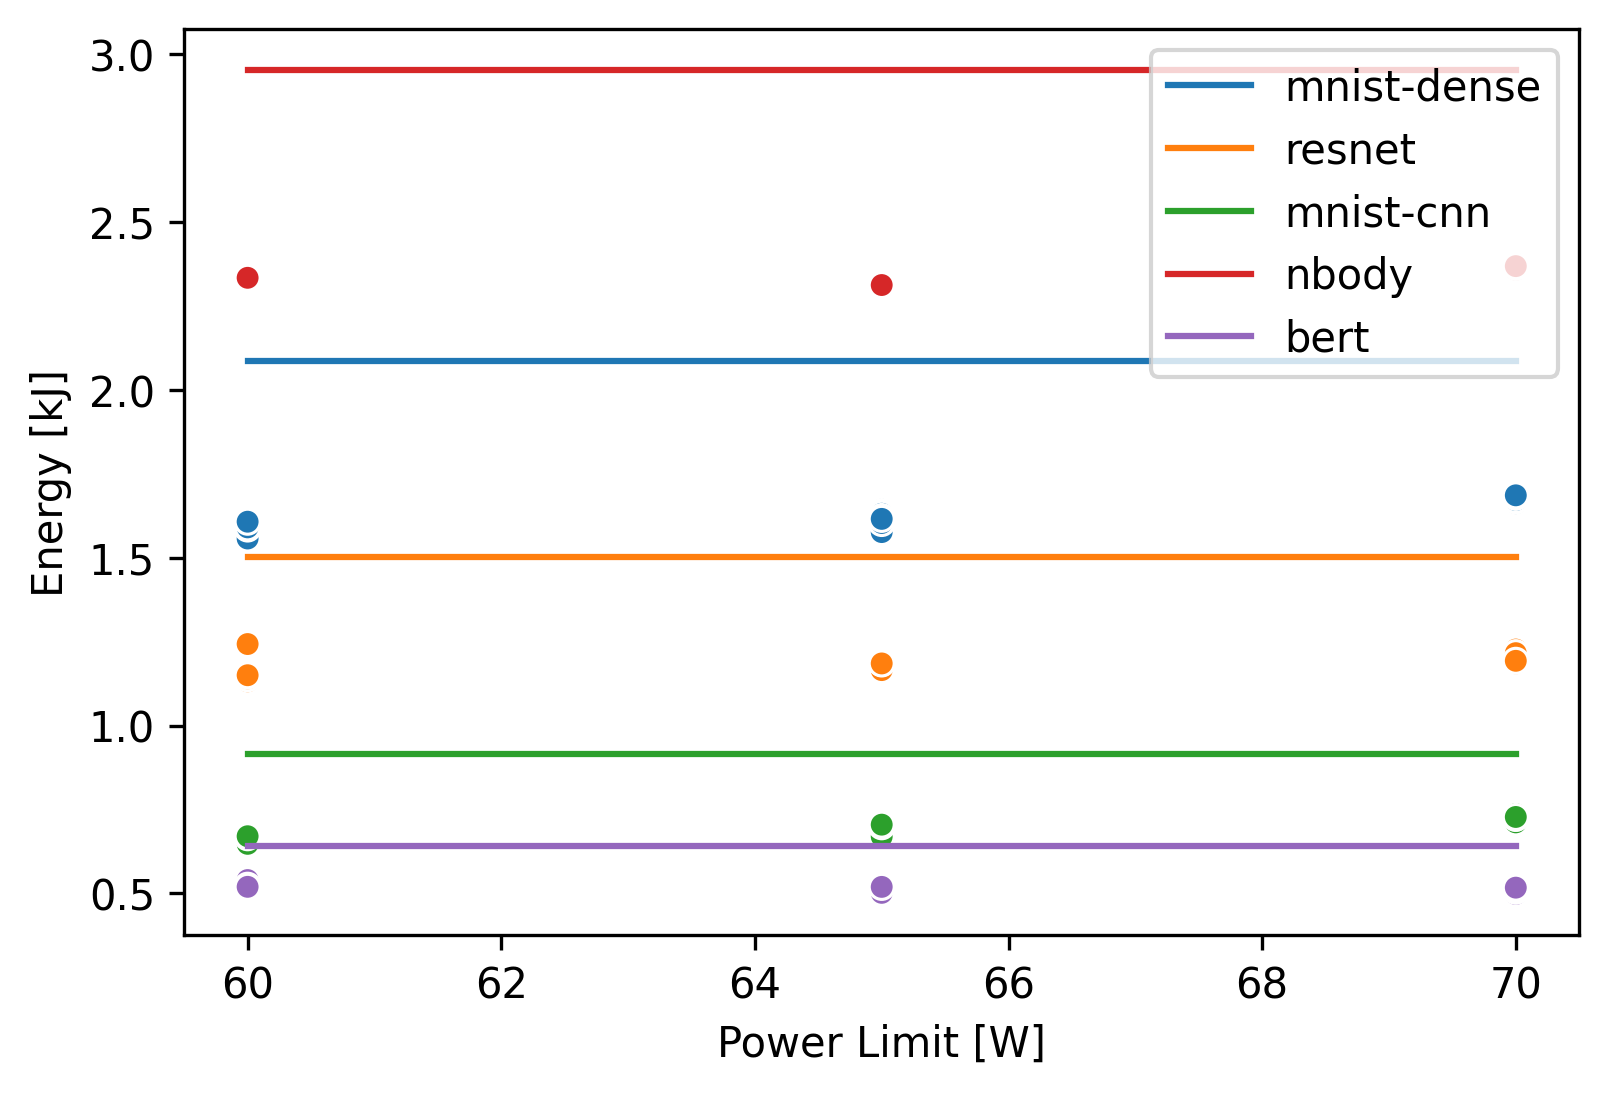

In [30]:
energy_model.plot(all_agg)
#plt.savefig("../master-thesis/images/energy-model-per-benchmark.pdf")

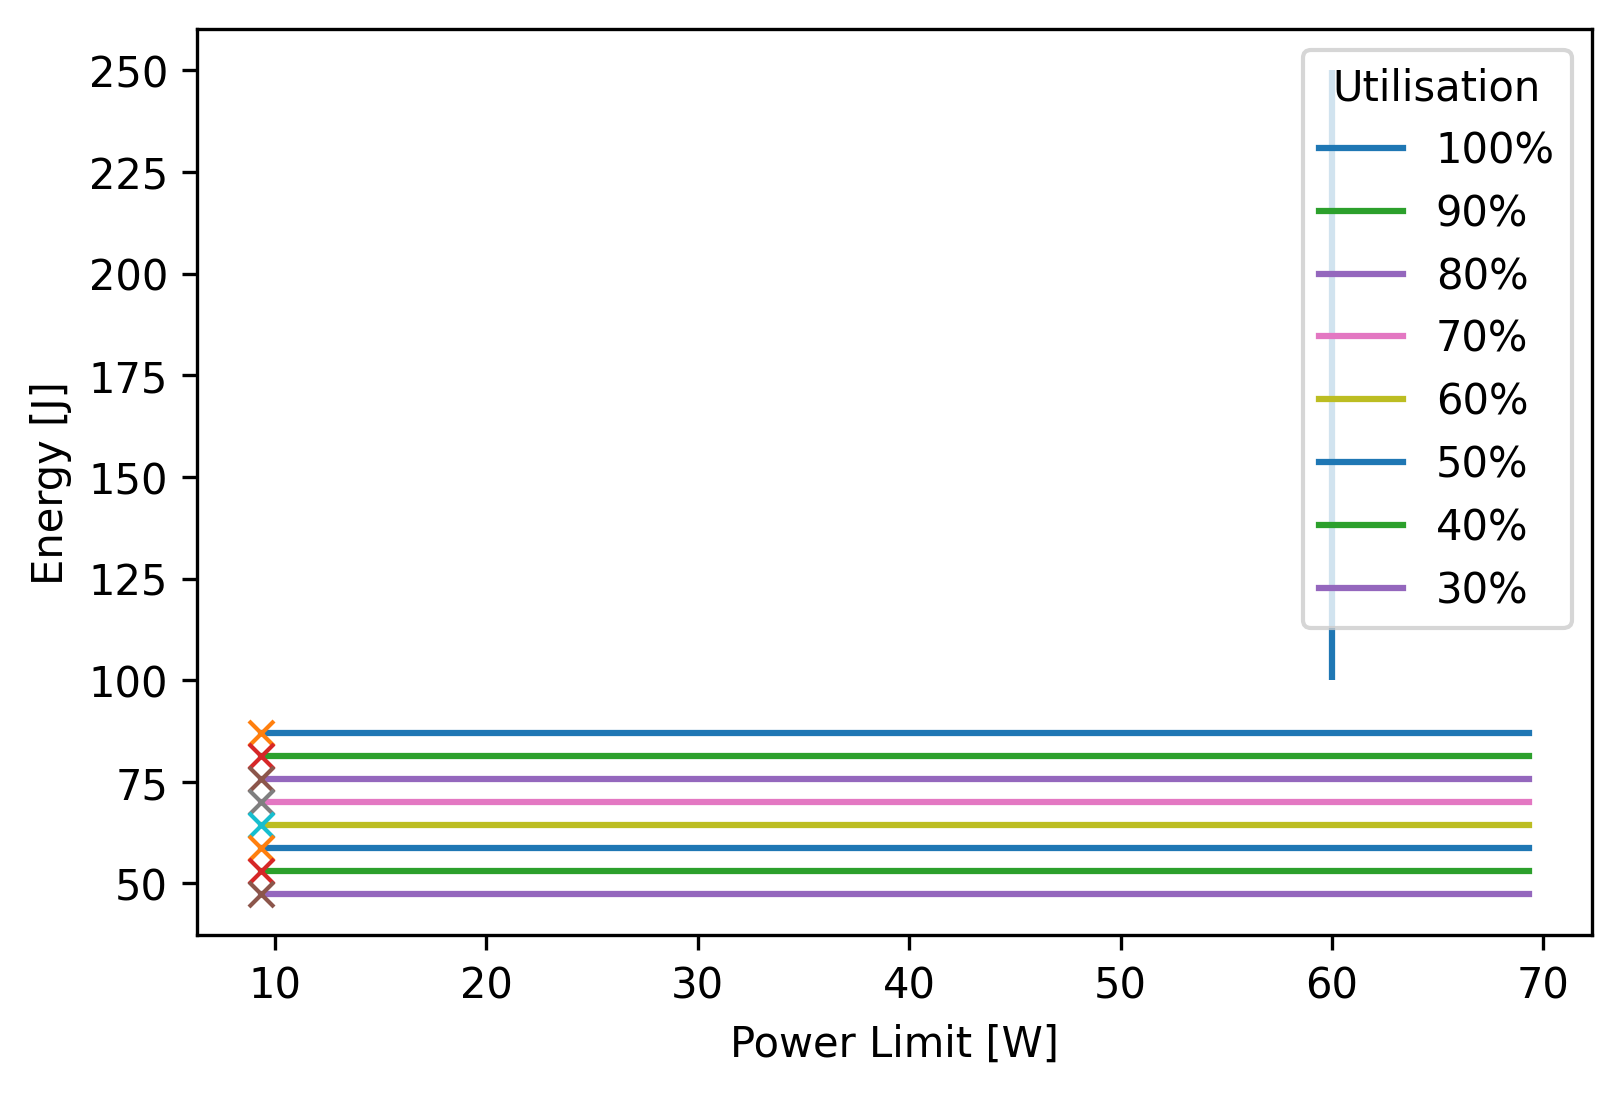

In [31]:
energy_model.visualize()
#plt.savefig("../master-thesis/images/energy-model-vis.pdf")

In [93]:
all_test = []
all_mses = []
for bench_name, test_data in all_agg.groupby("benchmark"):#
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    clock_model = ClockModel(p_max=p_max_nominal * 1.1, f_max=f_max)
    clock_model.fit(power_limit=train_data["enforced_power_limit"],
                p_util=train_data["p_util"],
                clock_gpu=train_data["clock_gpu"])
    
    power_model = PowerModel(baseline=p_baseline)
    power_model.fit(p_util=train_data["p_util"],
                    clock_gpu=train_data["clock_gpu"],
                    power=train_data["power"])
    
    
    delay_model = DelayModel()
    delay_model.fit(clock_gpu=train_data["clock_gpu"],
                        delay=train_data["delay"])
    
    energy_model = EnergyModel(delay_model=delay_model, power_model=power_model,
                           clock_model=clock_model,
                          p_min=p_min_nominal,
                          p_max=p_max_nominal)
    
    test_data["energy"] = test_data["energy"] + (power_model.baseline * test_data["timestamp"]) /1000
    
    test_data["energy_hat"] = energy_model.predict(p_util=test_data["p_util"],
                                                   power_limit=test_data["enforced_power_limit"],
                                                   time_reference=test_data["time_reference"])
    
    edp_model = EnergyDelayProductModel(delay_model=delay_model,
                                    clock_model=clock_model,
                                    energy_model=energy_model)
    
    test_data["edp_hat"] = edp_model.predict(power_limit=test_data["enforced_power_limit"],
                                            p_util=test_data["p_util"],
                                            time_reference=test_data["time_reference"])

    all_test.append(test_data)
    #mse_clock = mean_squared_error(test_data["energy"], test_data["energy_hat"])
    mse_clock = mean_squared_error(test_data["edp"], test_data["edp_hat"])
    all_mses.append(mse_clock)

all_test = pd.concat(all_test)
all_mses = np.array(all_mses)

In [96]:
np.sqrt(np.mean(all_mses)), np.sqrt(np.std(all_mses))

(5.042880677276693, 5.6106246248096205)

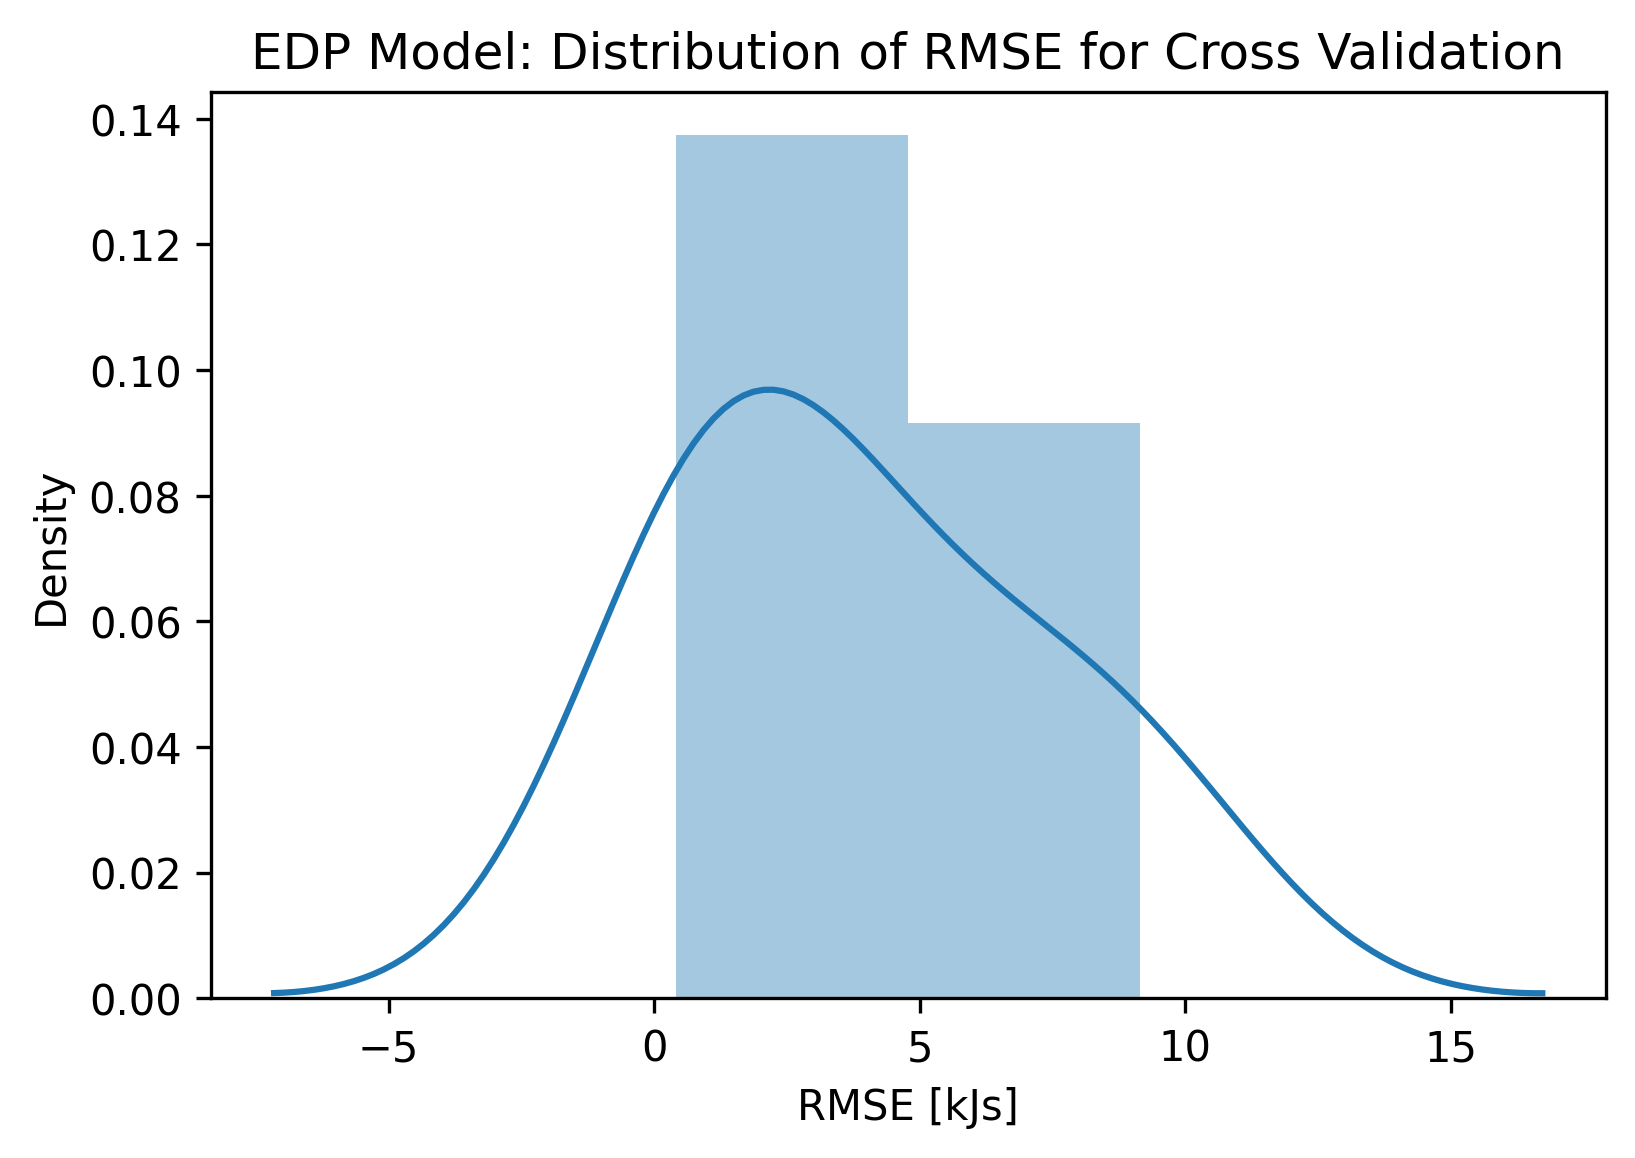

In [101]:
sns.distplot(np.sqrt(all_mses))
plt.title("EDP Model: Distribution of RMSE for Cross Validation")
plt.xlabel("RMSE [kJs]")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/energy-model-rmse.pdf")

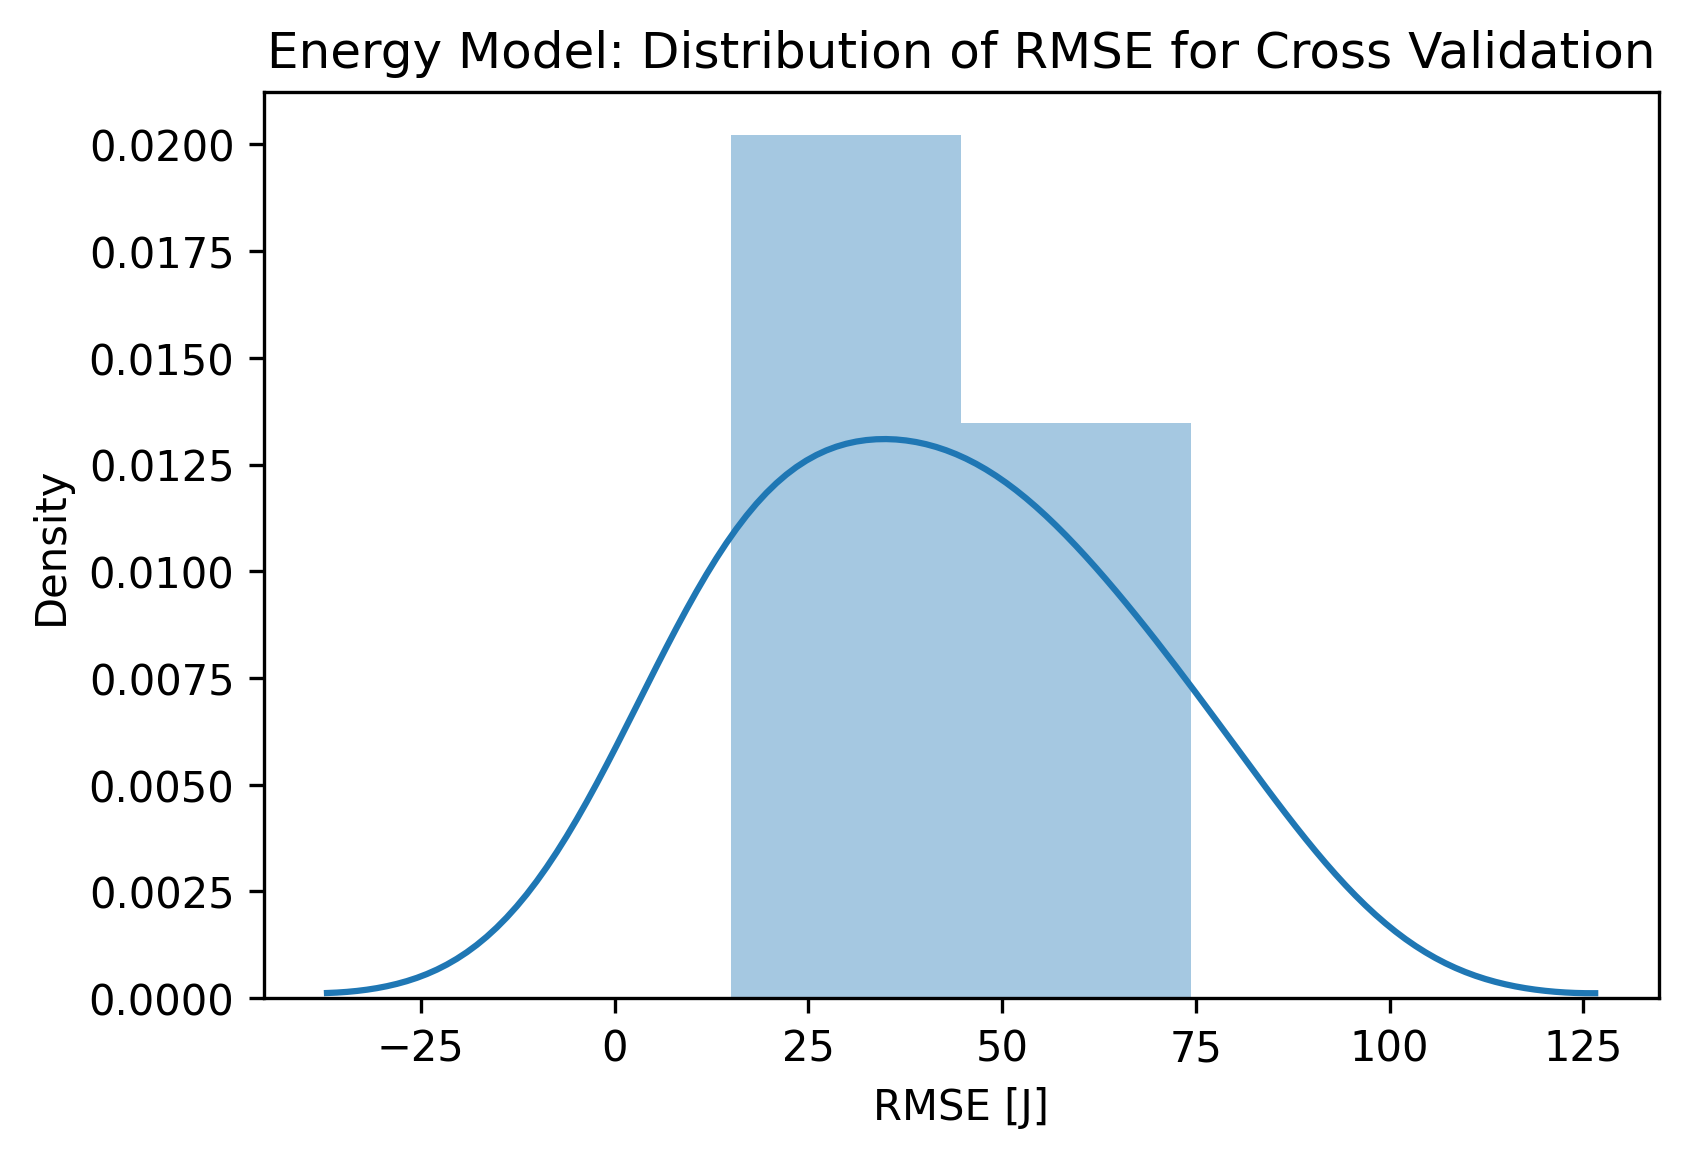

In [92]:
sns.distplot(np.sqrt(all_mses)*1000)
plt.title("Energy Model: Distribution of RMSE for Cross Validation")
plt.xlabel("RMSE [J]")
plt.ylabel("Density")
plt.savefig("../master-thesis/images/energy-model-rmse.pdf")

In [95]:
edp_model = EnergyDelayProductModel(delay_model=delay_model,
                                    clock_model=clock_model,
                                    energy_model=energy_model)

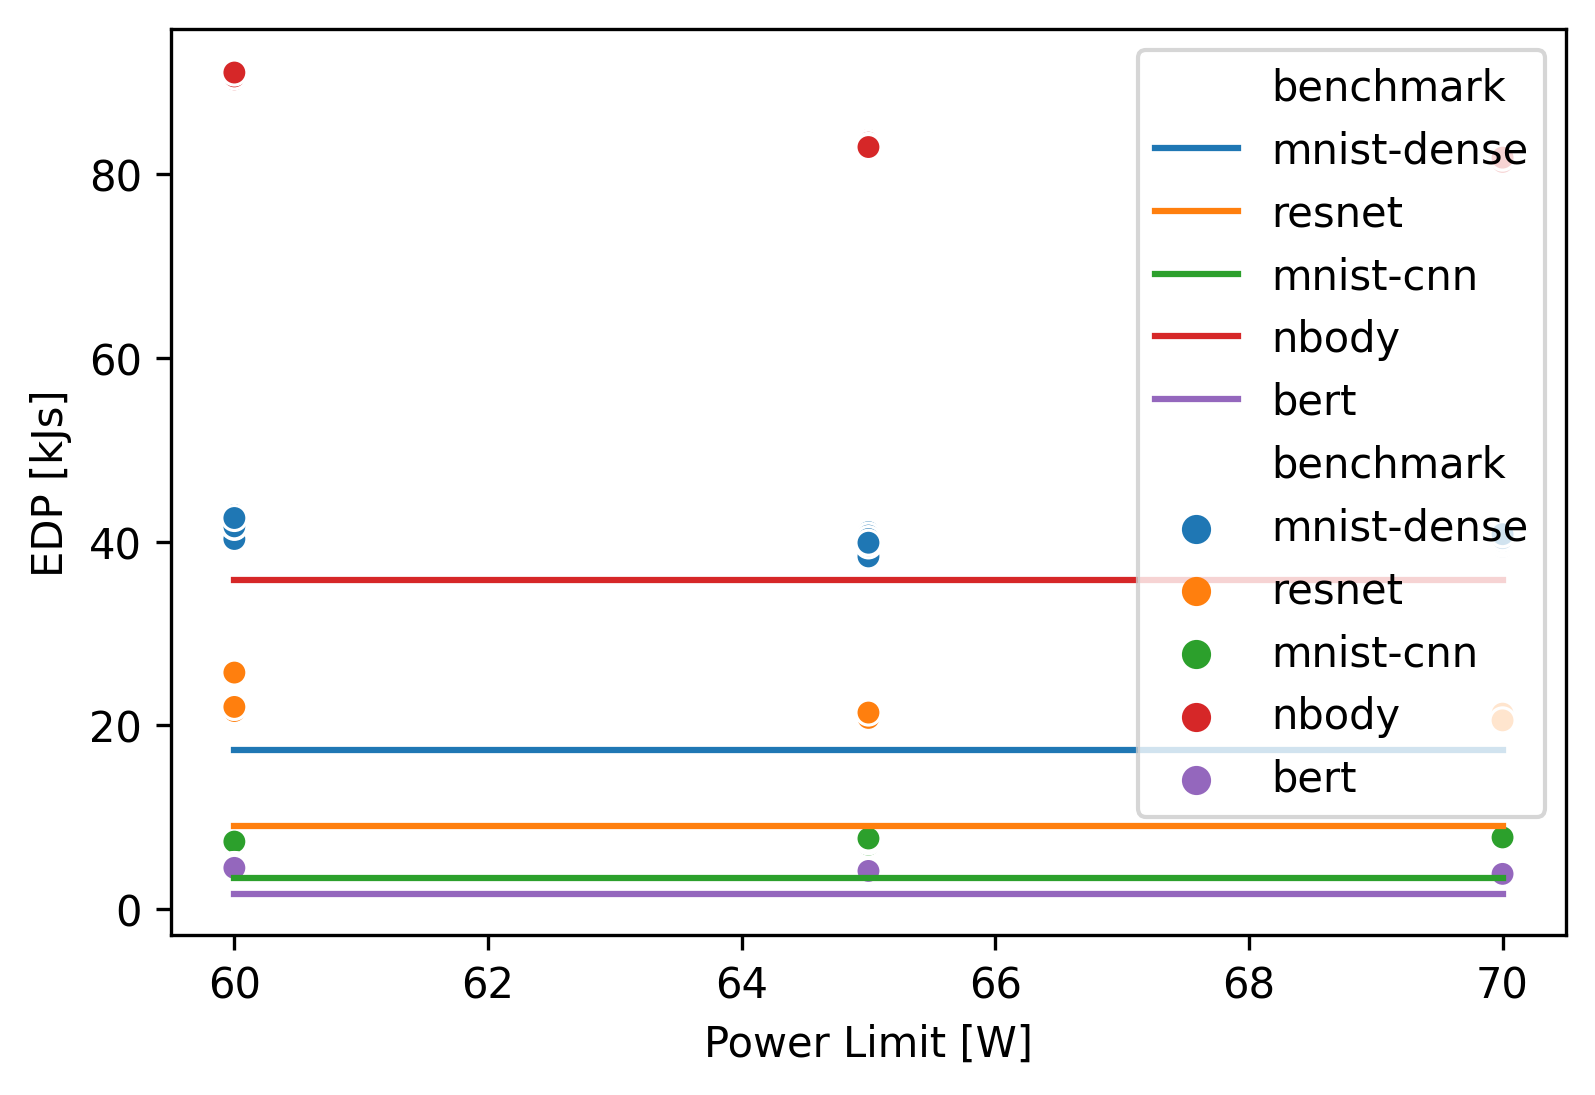

In [96]:
edp_model.plot(all_agg)
#plt.savefig("../master-thesis/images/edp-model-per-benchmark.pdf")

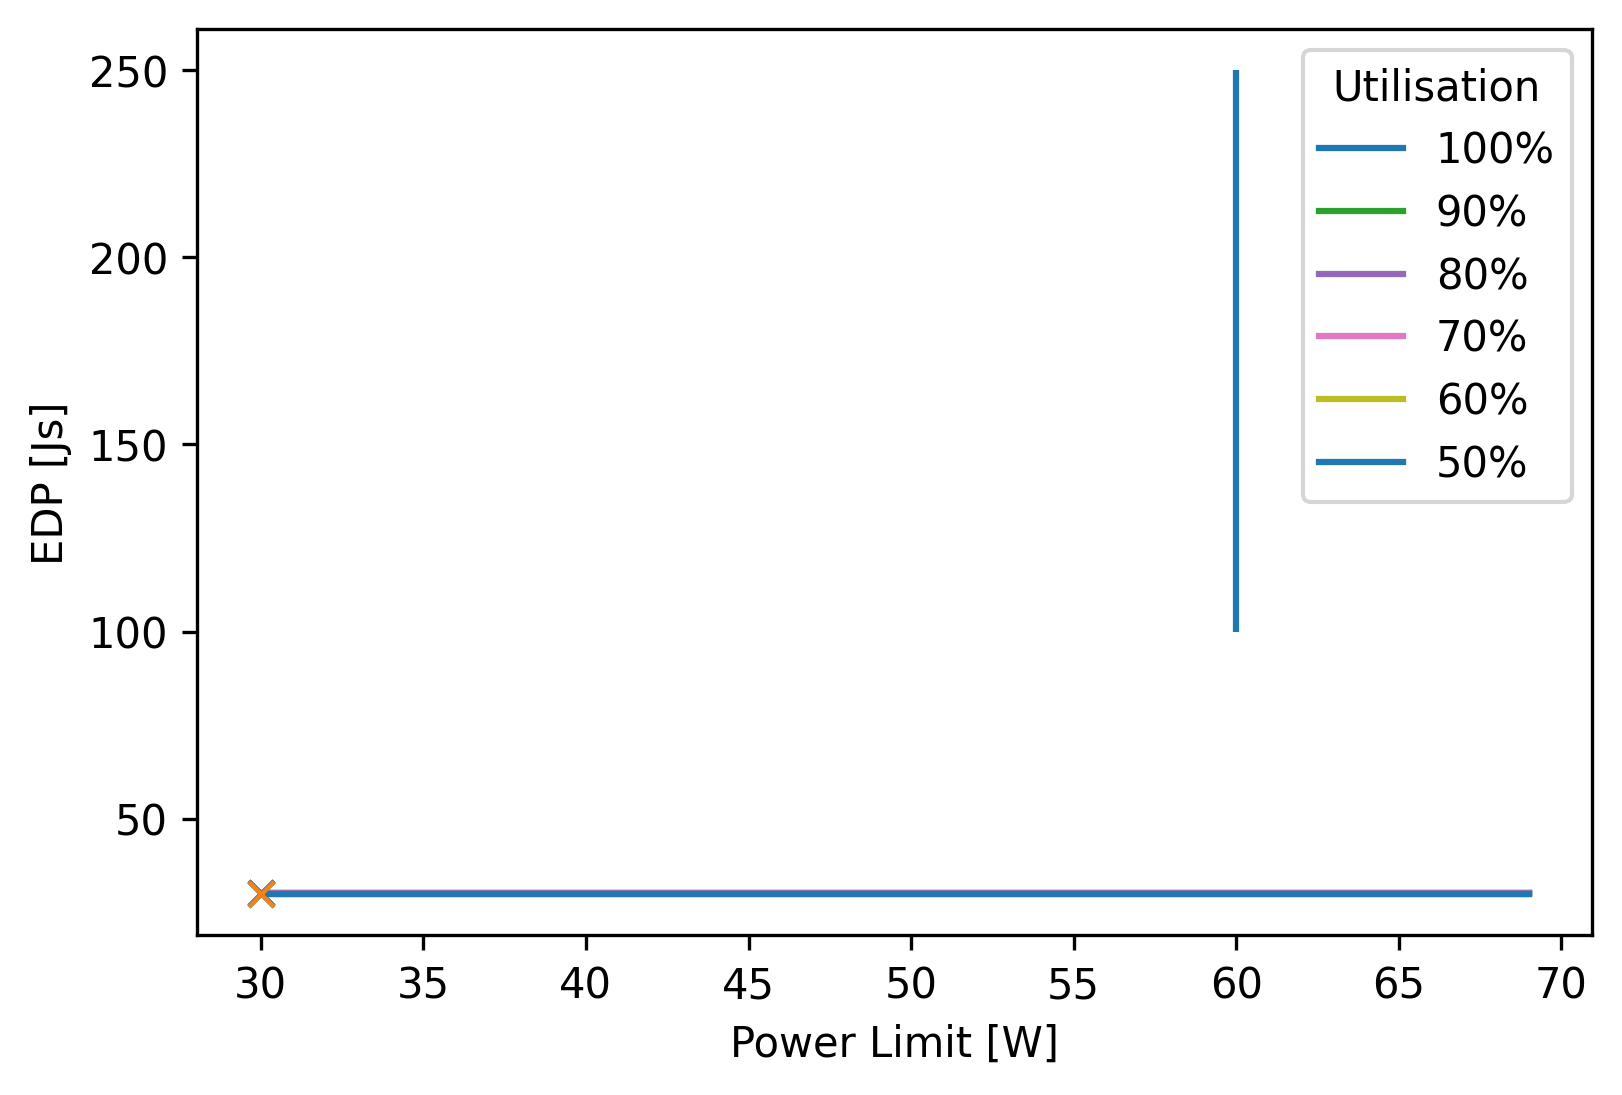

In [97]:
edp_model.visualize(util_min=50)
#plt.savefig("../master-thesis/images/edp-model-vis.pdf")

#### 